In [1]:
import pandas as pd
import altair as alt
import numpy as np

# Initial Beta Only

In [2]:
def run_sir_penn(beta, gamma, population, num_infected, N):
    i_n = num_infected
    s_n = population - i_n
    r_n = 0.
    inew_n = 1
    
    s_a, i_a, r_a, inew_a = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    
    for index in range(N):
        s_a[index] = s_n
        i_a[index] = i_n
        r_a[index] = r_n
        inew_a[index] = inew_n

        s = s_n
        i = i_n
        r = r_n
        inew = inew_n
        
        s_n = (-beta * s * i) + s
        i_n = (beta * s * i - gamma * i) + i
        r_n = gamma * i + r
        inew_n = (beta * s * i)
    return s_a, i_a, r_a, inew_a

In [3]:
infectious_days = 14.
doubling_rate = 3.5
population = 1000000.
num_infected = 100.
N = 250

gamma = 1 / infectious_days
growth_rate = 2 ** (1 / doubling_rate) - 1
beta = (growth_rate + gamma) / (population - 1)

s, i, r, i_new = run_sir_penn(beta, gamma, population, num_infected, N)

In [33]:
d = pd.DataFrame({
    'day': np.arange(len(s)), 
    'susceptable': s,
    'proportion_susceptable': s / s.max(),
    "infected": i, 
    "recovered": r, 
    "new_infections": i_new, 
    "infections_cumulative": np.cumsum(i_new),
    "penn_ever_infected": i + r,
})

(alt
 .Chart(d)
 .transform_fold(['susceptable', 'infected', 'recovered', 'new_infections', 'infections_cumulative'])
 .encode(x='day:Q', y="value:Q", color='key:N')
 .mark_line()
)

alt.Chart(...)

## Get $R_t$ for Each Day

### Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
import scipy.stats as sps
from scipy.interpolate import interp1d

### Constants

In [6]:
# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7
%config InlineBackend.figure_format = 'retina'

### Functions

In [7]:
from IPython.core.debugger import set_trace

def prepare_cases(cases, min_cases=25, win_size=7):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(
        win_size,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    idx_start = np.searchsorted(smoothed, min_cases)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

In [8]:
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

### Get Confidence Intervals

In [9]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

In [64]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_75'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_75'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig = plt.gcf()
    fig.set_facecolor('w')

### Get $R_t$ for Each Day of Actuals

In [61]:
def plot_rt_top(cases, axes, county_name="SIR Simulation"):
    cases_prepped, smoothed = prepare_cases(cases, min_cases=25)
    # Get cases plot
    ax = axes[0]
    ax.plot(
        cases_prepped.index, 
        cases_prepped.values, 
        c='k',
        linestyle=':',
        alpha=.5,
        label='Actual',
    )
    ax.set_title(f"Cases per Day ({county_name})")

    ax.plot(smoothed.index, 
            smoothed.values,
            label='Smoothed',
            )

    ax.legend()


    # Get R_t plot
    posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

    # Confidence Intervals
    # Note that this takes a while to execute - it's not the most efficient algorithm
    hdis = highest_density_interval(posteriors, p=.75)

    most_likely = posteriors.idxmax().rename('ML')

    # Look into why you shift -1
    result = pd.concat([most_likely, hdis], axis=1)

    # Plot R_t with intervals
    ax = axes[1]

    plot_rt(result, ax, county_name)
    ax.set_title(f'Real-time $R_t$ for {county_name}')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    return result
    
def display_counties(counties, convert_to_admits=False, **kwargs):
    if type(counties) is not list:
        counties = [counties]
    fig, axes = plt.subplots(nrows=len(counties), ncols=2, figsize=(1200/72,(400 * len(counties))/72))
    fig.set_facecolor('w')
    for county_name, axes in zip(counties, axes):
        cases = get_county_cases(county_name)
        if convert_to_admits:
            cases = county_to_admissions(cases, **kwargs)
        plot_rt(cases, axes)

In [25]:
d_trunc = d.iloc[:120].copy()
cases = (
    d_trunc
    [["infections_cumulative"]]
    .assign(date = pd.date_range("2020-03-20", periods=len(d_trunc), freq="D"))
    .set_index('date')
    .squeeze()
)

No handles with labels found to put in legend.


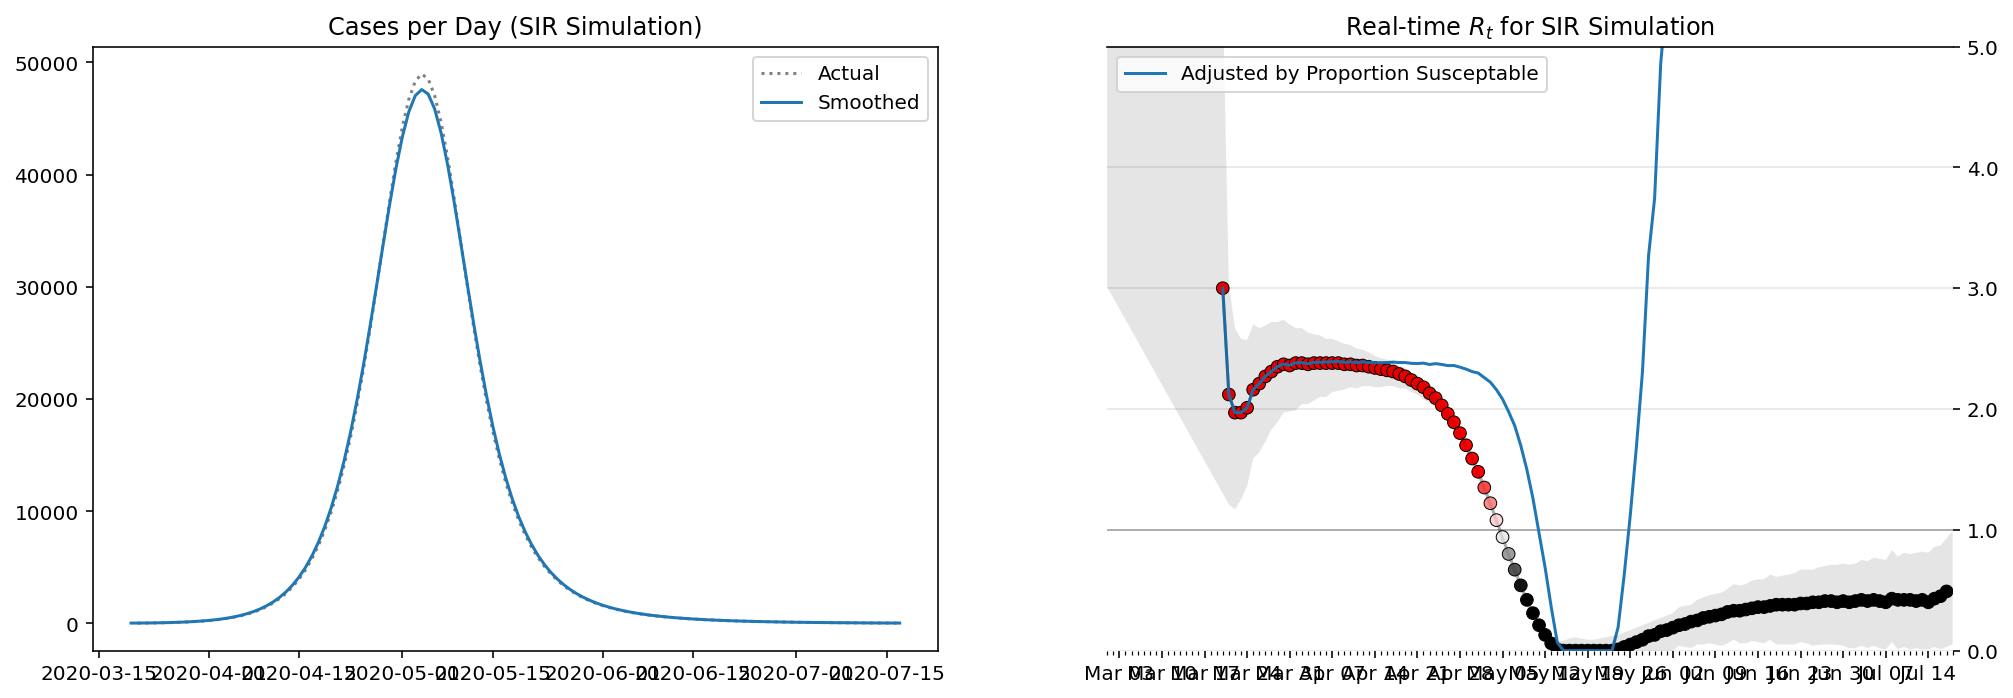

In [65]:
fix, axes = plt.subplots(1, 2, figsize=(1200/72, 400/72))
result = plot_rt_top(cases, axes)
axes[1].plot((result.ML / d.proportion_susceptable.iloc[:120].values), label="Adjusted by Proportion Susceptable")
axes[1].legend()

In [40]:
result

,ML,Low_75,High_75
date,,,
2020-03-20,3.00,1.30,5.44
2020-03-21,2.12,1.21,3.04
2020-03-22,1.97,1.17,2.67
2020-03-23,1.97,1.25,2.58
2020-03-24,2.01,1.36,2.57
...,...,...,...
2020-07-13,0.42,0.01,0.82
2020-07-14,0.40,0.01,0.81
2020-07-15,0.43,0.03,0.86


(0.0, 5.0)

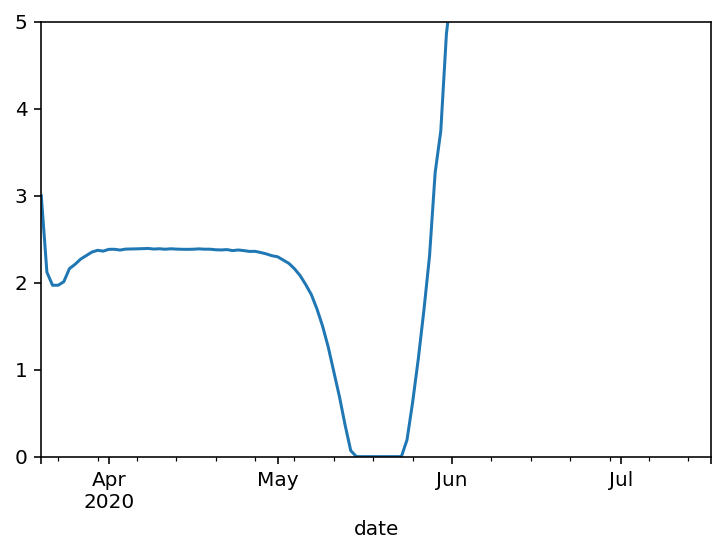

In [58]:
ax = (result.ML / d.proportion_susceptable.iloc[:120].values).plot()


In [50]:
result.ML

date
2020-03-20   NaN
2020-03-21   NaN
2020-03-22   NaN
2020-03-23   NaN
2020-03-24   NaN
              ..
2020-07-13   NaN
2020-07-14   NaN
2020-07-15   NaN
2020-07-16   NaN
2020-07-17   NaN
Name: ML, Length: 120, dtype: float64